### LSTM
1. skip-gram: LSTM testing accuracy 可達到 93 %
參考 https://keras-cn.readthedocs.io/en/latest/legacy/blog/word_embedding/

In [47]:
# basic libraries
import pandas as pd
import tensorflow as tf
import os
import re
import numpy as np
from string import punctuation
from zipfile import ZipFile
import matplotlib.pyplot as plt

# preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.tokenize.toktok import ToktokTokenizer
# generate word embedding
import gensim
from gensim.models import Word2Vec
from keras.layers import Embedding

# keras lstm model
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Activation, Dense, Dropout, Input, Embedding, SpatialDropout1D
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# evaluation
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns

In [49]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')


In [50]:
tokenizer = ToktokTokenizer()
corpus = [tokenizer.tokenize(document) for document in train['title']]
model = gensim.models.Word2Vec(corpus, min_count = 3, window = 5, sg = 1) # sg -> skip gram = true
model.train(corpus, total_examples=len(corpus), epochs = 5)

(1852057, 2094985)

In [51]:
vector = model.wv

In [52]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(num_words = 6000)
tokenizer.fit_on_texts(train['text'])
sequences = tokenizer.texts_to_sequences(train['text'])


In [53]:

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

data = pad_sequences(sequences, maxlen= 10000)

labels = train['label']
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)


Found 152495 unique tokens.
Shape of data tensor: (45316, 10000)
Shape of label tensor: (45316,)


In [54]:

# split the data into a training set and a validation set
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]
nb_validation_samples = int(0.2 * data.shape[0])

x_train = data[:-nb_validation_samples]
y_train = labels[:-nb_validation_samples]
x_val = data[-nb_validation_samples:]
y_val = labels[-nb_validation_samples:]

In [55]:
# test
tokenizer_test = Tokenizer(num_words = 5000)
tokenizer_test.fit_on_texts(test['text'])
sequences_test = tokenizer.texts_to_sequences(test['text'])
y_test = test['label']
data_test = pad_sequences(sequences_test, maxlen= 10000)
x_test = data_test


In [56]:
EMBEDDING_DIM = 100
embedding_matrix = np.zeros((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    try:
      embedding_vector = vector[word]
    except:
      embedding_vector = None
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

In [57]:
from keras.layers import Embedding
MAX_SEQUENCE_LENGTH = 10000
embedding_layer = Embedding(len(word_index) + 1,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False)
# Embedding(max_words, embed_dim, input_length = max_len)

In [58]:
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedded_sequences = embedding_layer(sequence_input)

lstm_out = 64
batch_size = 32


model = Sequential()
model.add(Embedding(len(word_index) + 1,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False))
model.add(LSTM(lstm_out))
model.add(Dense(256))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1, name='out_layer'))
model.add(Activation('sigmoid'))

model.compile(loss = 'binary_crossentropy', optimizer='adam',\
               metrics = ['accuracy'])
print(model.summary())


Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 10000, 100)        15249600  
                                                                 
 lstm_5 (LSTM)               (None, 64)                42240     
                                                                 
 dense_10 (Dense)            (None, 256)               16640     
                                                                 
 activation_7 (Activation)   (None, 256)               0         
                                                                 
 dropout_5 (Dropout)         (None, 256)               0         
                                                                 
 out_layer (Dense)           (None, 1)                 257       
                                                                 
 activation_8 (Activation)   (None, 1)                

In [59]:
history = model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=10, batch_size=128)


Epoch 1/10
284/284 [==============================] - 145s 497ms/step - loss: 0.3902 - accuracy: 0.8261 - val_loss: 0.4650 - val_accuracy: 0.7789
Epoch 2/10
284/284 [==============================] - 134s 472ms/step - loss: 0.3376 - accuracy: 0.8517 - val_loss: 0.3120 - val_accuracy: 0.8666
Epoch 3/10
284/284 [==============================] - 135s 477ms/step - loss: 0.2937 - accuracy: 0.8706 - val_loss: 0.2438 - val_accuracy: 0.8947
Epoch 4/10
284/284 [==============================] - 137s 484ms/step - loss: 0.3230 - accuracy: 0.8556 - val_loss: 0.2904 - val_accuracy: 0.8761
Epoch 5/10
284/284 [==============================] - 135s 476ms/step - loss: 0.2620 - accuracy: 0.8829 - val_loss: 0.2242 - val_accuracy: 0.8995
Epoch 6/10
284/284 [==============================] - 136s 478ms/step - loss: 0.2300 - accuracy: 0.9000 - val_loss: 0.2592 - val_accuracy: 0.8702
Epoch 7/10
284/284 [==============================] - 134s 471ms/step - loss: 0.2254 - accuracy: 0.8980 - val_loss: 0.2032 -

In [60]:
model.evaluate(x_test, y_test)

355/355 [==============================] - 46s 130ms/step - loss: 0.1689 - accuracy: 0.9309


[0.16893798112869263, 0.9308914542198181]

([<matplotlib.axis.XTick at 0x7f5e2de3dbd0>,
 <a list of 10 Text major ticklabel objects>)

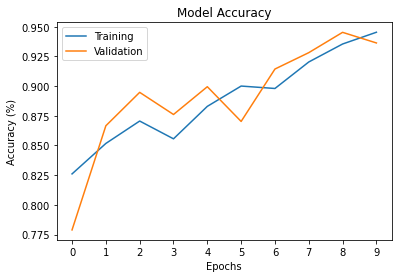

In [61]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.legend(['Training', 'Validation'])
plt.ylabel('Accuracy (%)')
plt.xlabel('Epochs')
plt.xticks(np.arange(10))

([<matplotlib.axis.XTick at 0x7f5e2de33490>,
 <a list of 10 Text major ticklabel objects>)

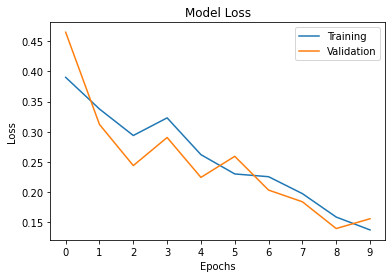

In [62]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.legend(['Training', 'Validation'])
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.xticks(np.arange(10))

---